In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
#Helper Functions
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0 , 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #TODO: consider about the curve lanes
    #1) initialize variables
    left_slope = []
    right_slope = []
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    min_y = 330 #imshape[0]/2 +60
    max_y = img.shape[0]
    
    #2) check segments that are parts of left or right lines fill that in accordingly into lists
    for line in lines:
        for x1, y1, x2, y2 in line:
            if y1 < min_y:
                min_y = y1
            
            slope = (y2-y1)/(x2-x1)
            #right line
            if -0.8 < slope < -0.4:
                right_slope.append(slope)
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
            elif 0.8 > slope > 0.4:
                left_slope.append(slope)
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
    #3) extrapolate the lines using average for both left and right
    #3.1) right side
    avg_right_slope = np.mean(right_slope)
    avg_right_x = np.mean(right_x)
    avg_right_y = np.mean(right_y)
    #b = y - mx
    right_intercept = avg_right_y - avg_right_slope * avg_right_x
    #x = (y - b)/m
    right_x1 = (min_y - right_intercept) / avg_right_slope
    right_x2 = (max_y - right_intercept) / avg_right_slope
    #3.2) left side
    avg_left_slope = np.mean(left_slope)
    avg_left_x = np.mean(left_x)
    avg_left_y = np.mean(left_y)
    #b = y - mx
    left_intercept = avg_left_y - avg_left_slope * avg_left_x
    #x = (y - b)/m
    left_x1 = (min_y - left_intercept) / avg_left_slope
    left_x2 = (max_y - left_intercept) / avg_left_slope
    
    #4) draw lines
    cv2.line(img, (int(right_x1), int(min_y)), (int(right_x2), int(max_y)), color, thickness)
    cv2.line(img, (int(left_x1), int(min_y)), (int(left_x2), int(max_y)), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=5)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.    
    `initial_img` should be the image before any processing.    
    The result image is computed as follows:    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
def process_image(org_img):

    imshape = org_img.shape
    #1) convert to hsv color space
    image = grayscale(org_img)
    #2) apply gaussian blur
    image = gaussian_blur(image, 3)
    #3) detect the edges with canny edge detection
    image = canny(image, 30, 120)
    #4) limit region of interest
    vertices = np.array([[(40,imshape[0]),
                          ((imshape[1]/2) - 40, imshape[0]/2 +60), 
                          ((imshape[1]/2) + 40, imshape[0]/2 +60), 
                          (imshape[1] -40,imshape[0])]], dtype=np.int32)
    image = region_of_interest(image, vertices)
    #5) apply the hough lines
    image = hough_lines(image, 1, np.pi/90, 10, 15, 10)
    #6) overlay the line image onto the original image
    overlay_img = weighted_img(image, org_img)
    return overlay_img

This image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


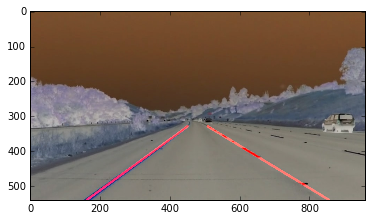

In [5]:
org_image = (mpimg.imread('./test_images/solidYellowCurve.jpg')*255).astype('uint8')
#printing out some stats and plotting
print ('This image is: ', type(org_image), 'with dimensions: ', org_image.shape)
org_image = process_image(org_image)
plt.imshow(org_image, cmap='gray') # call as plt.imshow(gray, cmap='gray') to show gray scale image
plt.show()

In [6]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 39.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.49 s, sys: 721 ms, total: 3.21 s
Wall time: 6.38 s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [8]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:18<00:00, 36.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 7.76 s, sys: 1.35 s, total: 9.11 s
Wall time: 19.7 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Reflections

#### 1) Convert the image to gray scale, 2) smoothing out the image, 3) detect edges using canny edge etection, 4) trying to find vertics to mask the region of interest. And find the hough lines then draw it. Overlay on to the original image. Above is the pipe line that I use to solve this project. I did not really use one of the tols that is in this lesson which is color selection. 

#### There are multiple shortcomings. One of the main thing is that I could not come up with the good values to cover optional challenge video. It might be the slope that I chose, it might be selection of the color that I am interested in and it might be the drawing methods that I used to average out and draw the lines instead of finding the closet two points and draw a line for those tow points and on. That way I can cover the curve roads like drawing the shape points. Another big one is that I am not aware of all the open cv API's and color spaces that available to me. I think it might be a way to filter out the color that I am interested in some color space.

#### And also if I know better about probablistic Hough Trasform algorithm, it might help. So, I fialed to finish the challege part which I will come back to work on it since this class is very fast pace and I can barely give times to this calss with my day job and with family times that I committed. Not sure if I can kep this pace for the whole three terms. 

#### Another thing is that working with jupyter notebook which is not a problem and it is platform independent but I like to work on the native so I can test it right away. I finihsed this project with this technique, try testing everything using command line and then copied all the source on to Jupyter, run and test it again. If I can b able to submit project with pythin file only, that'd be great. Not sure about we still have to use jupyter for deep learning section and the other future sections.

#### But this is a good expereince and I learned something from this lesson and I know I need to keep up with the class's pace.